# Introduction

In recent years, deep learning has transformed medical imaging, offering unprecedented accuracy in disease detection and classification tasks. Traditionally, **Convolutional Neural Networks (CNNs)** have been the primary tool for these tasks, especially for image classification. However, with the continuous evolution of deep learning architectures, **Vision Transformers (ViTs)** are emerging as a powerful alternative to CNNs, particularly in the context of medical image analysis.

Vision Transformers bring the power of **transformer architectures**, initially designed for natural language processing, into the field of computer vision. By treating image patches as sequences, Vision Transformers effectively capture both global and contextual information across an image—making them highly effective in identifying subtle patterns in medical images, such as **X-rays**.

In this notebook, we will demonstrate the use of **Vision Transformers for image classification** in a real-world medical imaging scenario: **pneumonia detection from chest X-rays**. Pneumonia detection is a critical task in healthcare, and early diagnosis can significantly improve patient outcomes, making it an ideal case study for applying Vision Transformers.

### Objectives:
- Understand how Vision Transformers work and why they are effective for medical image classification.
- Preprocess and augment chest X-ray images to enhance model performance.
- Implement and train a Vision Transformer model for pneumonia detection.
- Evaluate the model's performance using metrics such as accuracy, precision, recall, and F1-score.

By the end of this notebook, you'll gain insights into how Vision Transformers can be leveraged to improve diagnostic accuracy in medical imaging, presenting a novel approach to healthcare-focused deep learning.

Let's dive into the world of Vision Transformers and explore their application in **medical image classification**!


# Import

In [1]:
import os
import numpy as np
import math
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision.transforms import functional as TF
from torch.utils.tensorboard import SummaryWriter



from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
from sklearn.metrics import classification_report


In [2]:
# Directories for training and validation data
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'  # Update with your training directory path
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'      # Update with your validation directory path

# Function to check if the image file is valid
def is_valid_image(filepath):
    try:
        img = Image.open(filepath)
        img.verify()  # Verify that it's a valid image
        return True
    except (IOError, SyntaxError):
        return False

# Function to clean directories from invalid images
def clean_directory(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            filepath = os.path.join(root, file)
            if not is_valid_image(filepath):
                print(f"Removing invalid image: {filepath}")
                os.remove(filepath)

# Clean both train and validation directories
clean_directory(train_dir)
clean_directory(val_dir)

# Data Processing: Understanding Patches in Vision Transformers

In traditional **Convolutional Neural Networks (CNNs)**, images are processed by applying convolutional filters across the entire image. However, in **Vision Transformers (ViTs)**, we take a different approach: we split the image into smaller, non-overlapping patches and treat each patch as a token, similar to how words are treated in **Natural Language Processing (NLP) transformers**.

### Why Do We Use Patches?

Vision Transformers were inspired by the success of transformers in NLP, where sequences of words (tokens) are processed. For images, instead of feeding the entire image directly to the transformer, the image is divided into smaller patches. These patches serve as input tokens for the transformer. Here's why this approach is effective:

- **Dimensionality Reduction**: Images often contain a large number of pixels, especially when dealing with high-resolution images. Feeding the entire image into a transformer would result in extremely high computational costs. By splitting the image into patches, we reduce the dimensionality of the input, making it manageable for the transformer to process.

- **Structured Sequence Input**: Transformers are inherently designed to process sequences of data (such as words or tokens). By converting images into patches, we transform the 2D image into a sequence of patches, allowing the Vision Transformer to leverage its sequence-processing capabilities.

- **Global Context Awareness**: Unlike CNNs, which are better at capturing local patterns through convolutional layers, transformers are excellent at modeling long-range dependencies. By splitting the image into patches, each patch contains local information, while the transformer learns the global relationships between patches, providing a more holistic understanding of the image.

### Patch Extraction Process

In this notebook, we will split each image into non-overlapping patches of a fixed size. These patches are then flattened and projected into a vector space, becoming input tokens for the transformer. For example, an image of size `224x224` might be divided into patches of size `16x16`, resulting in 196 patches (`224 / 16 = 14` patches along each dimension, and `14 x 14 = 196` total patches).

Each of these patches is treated as a separate token, and the transformer learns to attend to these patches to make image-level predictions.

### Steps in Patch Extraction:

1. **Resize**: The input image is resized to a fixed dimension (e.g., `224x224`) to ensure consistency across the dataset.
2. **Patch Division**: The resized image is divided into smaller patches (e.g., `16x16` patches).
3. **Flattening**: Each patch is flattened into a 1D vector.
4. **Projection**: These flattened patches are projected into a higher-dimensional space to be used as input tokens for the Vision Transformer model.

By using patches, we not only reduce the computational complexity but also harness the transformer’s strength in modeling relationships between different parts of the image. This enables more accurate predictions, especially in complex tasks like **medical image classification**.

Let's now dive into the process of extracting patches from our dataset and preparing them for the Vision Transformer model.


In [3]:
class PatchExtractor:
    def __init__(self, patch_size, stride):
        self.patch_size = patch_size
        self.stride = stride

    def __call__(self, img):
        # img is a tensor of shape [C, H, W]
        C, H, W = img.shape
       
        patches = img.unfold(1, self.patch_size, self.stride).unfold(2, self.patch_size, self.stride)
        # Reshape patches to [num_patches, C, patch_size, patch_size]
        num_patches = patches.size(1) * patches.size(2)
        patches = patches.contiguous().view(C, num_patches, self.patch_size, self.patch_size)
        # Transpose to [num_patches, C, patch_size, patch_size]
        patches = patches.permute(1, 0, 2, 3)
        return patches

patch_size = 16
stride = 16


train_transforms = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.RandomHorizontalFlip(p=0.5),  # Flip with a probability of 50%
    transforms.RandomRotation(degrees=15),   # Rotate by ±15 degrees
    transforms.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),  # Crop and resize
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1)),  
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
    PatchExtractor(patch_size=patch_size, stride=stride),
])


test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalizes to range [-1, 1]
    PatchExtractor(patch_size=patch_size, stride=stride)
])

# Load datasets
train_dataset = datasets.ImageFolder(root='/kaggle/input/chest-xray-pneumonia/chest_xray/train', transform=train_transforms)
test_dataset = datasets.ImageFolder(root='/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


#data_iter = iter(train_loader)
#patches, labels = next(data_iter)

#print(f'Number of patches: {patches.size(1)}')
#print(f'Patch size: {patches.shape[2:]}')  # Should be [C, patch_size, patch_size]


# Vision Transformer (ViT) Model for Medical Image Classification

This section describes the architecture and components of the Vision Transformer (ViT) model used in this notebook. The ViT is tailored for medical image classification tasks, such as pneumonia detection from X-ray images. Below is a detailed breakdown of the key components and how they work together.

---

## 1. Patch Embedding Layer (`Embedding_VIT`)

In the Vision Transformer, images are divided into smaller patches and processed as sequences. This is done by embedding the patches into vectors, which are then passed to the transformer encoder.

- **Patch Division**: The input image is divided into small non-overlapping patches.
- **Convolutional Layers**: Each patch is passed through several 1D convolutional layers (`conv1`, `conv2`, etc.) to extract features from each patch.
- **Linear Projection**: After convolution, a linear layer projects the flattened patches into a higher-dimensional space (`linear`), which acts as the input embedding for the transformer.

These embeddings form the input tokens for the transformer model.

---

## 2. Positional Encoding and CLS Token

Since transformers do not inherently capture spatial information, we add positional encodings to the patch embeddings.

- **Positional Encoding**: A learnable positional encoding (`pos_embedding`) is added to the patch embeddings, providing the model with spatial context about the position of each patch.
- **CLS Token**: A special classification token (`cls_token`) is prepended to the sequence of patch embeddings. This token aggregates information from all the patches and is used for the final classification task.

---

## 3. Transformer Encoder Layers

The core of the Vision Transformer is the **Encoder** block, which consists of multiple layers (6 layers in this case). Each encoder layer contains:

- **Multi-Head Self-Attention (`attn`)**: The multi-head attention mechanism allows the model to capture relationships between all patches, helping it understand both local and global features.
- **Feed-Forward Layers**: After the attention operation, the output is passed through two fully connected layers (`linear1`, `linear2`), separated by a GELU activation.
- **Layer Normalization and Residual Connections**: Each encoder layer includes layer normalization (`norm1`, `norm2`) and skip connections to stabilize training and improve convergence.

The sequence of patches, along with the CLS token, is passed through all six encoder layers.

---

## 4. Classification Head

After passing through the transformer layers, the output corresponding to the **CLS token** is used for classification:

- **Fully Connected Layer (`fc`)**: The output of the CLS token is passed through a final fully connected layer, which generates predictions for the target class (e.g., detecting pneumonia).

---

## 5. Focal Loss

For training, the model uses **Focal Loss**, which is particularly useful for dealing with class imbalance in medical datasets. Focal Loss adjusts the importance of hard-to-classify examples, helping the model focus on difficult cases (such as rare instances of pneumonia).

- **Alpha and Gamma Parameters**: These parameters control the weighting of easy and hard examples, with `alpha` adjusting class imbalance and `gamma` focusing on difficult cases.

---

## 6. Training and Inference

The model is trained using a combination of mixed-precision training and gradient clipping to prevent overfitting and improve stability.

- **Training**: The model is trained with optimizer updates using stochastic gradient descent and periodic checkpointing.
- **Inference**: During inference, the model is evaluated on unseen data using the trained CLS token output to generate predictions.

---

## Summary

In this implementation, the Vision Transformer is designed to process images by treating image patches as input tokens. The model captures both local and global information using attention mechanisms, making it well-suited for tasks such as pneumonia detection from chest X-rays. The model incorporates important techniques such as focal loss and multiple encoder layers to improve accuracy on imbalanced medical datasets.


In [133]:
class Embeding_VIT(nn.Module):
    def __init__(self,patch_dim):
        super(Embeding_VIT, self).__init__()
        
        self.linear = nn.Linear(in_features = 700,out_features = 256)
        
        
        self.conv1 = nn.Conv1d(in_channels  = 196,out_channels = 196,kernel_size = 21,
                               #stride = 1,padding = 1, dilation = 1
                              )
        self.conv2 = nn.Conv1d(in_channels  = 196,out_channels = 196,kernel_size = 21,
                               #stride = 1,padding = 1, dilation = 1
                              )
        self.conv3 = nn.Conv1d(in_channels  = 196,out_channels = 196,kernel_size = 21,
                               #stride = 1,padding = 1, dilation = 1
                              )
        self.conv4 = nn.Conv1d(in_channels  = 196,out_channels = 196,kernel_size = 9,
                               #stride = 1,padding = 1, dilation = 1
                              )

        
    def forward(self, x):
        
            
        x = self.conv1(x)
        x = F.gelu(x)
        
        x = self.conv2(x)
        x = F.gelu(x)
        
        x = self.conv3(x)
        x = F.gelu(x)
        
        x = self.conv4(x)
        x = F.gelu(x)
        
        x = self.linear(x)

        return x

In [134]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.attn = torch.nn.MultiheadAttention(embed_dim = 256,
                                                num_heads=8,
                                                dropout=0.1,
                                                batch_first=True)
        
        self.linear1 = nn.Linear(in_features = 256,out_features = 1024)
        self.linear2 = nn.Linear(in_features = 1024,out_features = 256)
        
        self.norm1 = nn.LayerNorm(normalized_shape = 256)
        self.norm2 = nn.LayerNorm(normalized_shape = 256)
        
        self.dropout1 = torch.nn.Dropout(0.2)
        self.dropout2 = torch.nn.Dropout(0.2)
        self.dropout3 = torch.nn.Dropout(0.2)
        
    def forward(self,x,attn_mask=None,key_padding_mask=None):

        x_tmp = self.norm1(x)

        x_tmp, _ = self.attn(query=x_tmp,
                             key=x_tmp,
                             value=x_tmp,
                             attn_mask=attn_mask,
                             key_padding_mask=key_padding_mask)

        x_tmp = self.dropout1(x_tmp)
        x = x + x_tmp
        
        x_tmp = self.norm2(x) 
        x_tmp = self.linear1(x_tmp)
        x_tmp = F.gelu(x_tmp)
            
        x_tmp = self.dropout2(x_tmp)
        x_tmp = self.linear2(x_tmp)
        x_tmp = self.dropout3(x_tmp)
        x = self.norm1(x + x_tmp)
        
            
        return x

In [135]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduce = reduce

    def forward(self, inputs, targets):
     
        inputs = inputs.view(-1)
        targets = targets.view(-1).float()

   
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)  
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss


        if self.reduce:
            return F_loss.mean()
        else:
            return F_loss


In [136]:
class VisionTransformer(nn.Module):
    def __init__(self,device,image_size, patch_size, num_classes, channels=3):
        super(VisionTransformer, self).__init__()

        assert image_size % patch_size == 0, "Image dimensions must be divisible by the patch size."
        num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size * patch_size
        

        self.norm1 = nn.LayerNorm(patch_dim)
        self.patch_embedding = Embeding_VIT(patch_dim)
        #self.patch_embedding = nn.Linear(in_features = patch_dim,out_features = 256)
        
        
        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, 256))
        self.cls_token = nn.Parameter(torch.randn(1, 1, 256))
        

        self.encode1 = Encoder()
        self.encode2 = Encoder()
        self.encode3 = Encoder()
        self.encode4 = Encoder()
        self.encode5 = Encoder()
        self.encode6 = Encoder()


        self.fc = nn.Linear(256, num_classes)
        
        self.device = device
        
    def forward(self, x):
        x = x.to(self.device)
        batch_size, num_patches, channels, patch_size, _ = x.size()
        x = x.view(batch_size, num_patches, -1)
        
        x = self.norm1(x)
        x = self.patch_embedding(x)

        cls_tokens = self.cls_token.expand(batch_size, -1, -1)  # [batch_size, 1, 256]
        x = torch.cat((cls_tokens, x), dim=1) 
        
        x = x + self.pos_embedding[:, :(num_patches + 1)].to(x.device, dtype=x.dtype)
        
        x = self.encode1(x)
        x = self.encode2(x)
        x = self.encode3(x)
        x = self.encode4(x)
        x = self.encode5(x)
        x = self.encode6(x)
        
        x = x[:, 0] 
        
        x = self.fc(x)
        
        return x 
    
    def calculate_test_loss(self, test_loader, criterion):
        self.to(self.device) 
        loss_mean = 0.0
        self.eval()
        with torch.no_grad():
            for i, batch in enumerate(test_loader):
                patches, label = batch[0].cuda(), batch[1].cuda()
          
                output = self(patches)
                test_loss = criterion(output, label)

                loss_mean += test_loss.item()

        loss_mean = np.round(loss_mean/(i+1), 5)
        return loss_mean

    @torch.no_grad()
    def inference(self, patches):
        self.eval() 

       
        patches = patches.to(next(self.parameters()).device)

        
        output = self(patches)
        return output
    
    def train_model(self, train_loader, 
                    test_loader, optimizer, 
                    scaler, criterion, 
                    train_saved_path, test_saved_path,epoch = None):
        
        self.to(self.device) 

        best_train_loss = float("inf")
        best_test_loss = float("inf")
        ep = 0
        
        if os.path.isfile("/kaggle/working/VIT_train.pt_"):
            state = torch.load("/kaggle/working/VIT_test.pt_")
            self.load_state_dict(state["model"])
            optimizer.load_state_dict(state["optimizer"])
            ep = state["epoch"] + 1
            best_train_loss = state.get("train_loss", float("inf"))
            best_test_loss = state.get("test_loss", float("inf"))
            print(f"Continue training from epoch {ep} with train_loss: {best_train_loss} and test_loss: {best_test_loss}")
        else:
            print("Start from Scratch")
            
        in_train = True  
        while in_train:
            self.train()
            train_loss = 0.0

            for i, batch in enumerate(train_loader):
                patches, label = batch[0].cuda(), batch[1].cuda()  

                optimizer.zero_grad()  

                with torch.cuda.amp.autocast():
                    output = self(patches)
                    loss = criterion(output, label)

                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(self.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()

                train_loss += loss.item()

            test_loss = self.calculate_test_loss(test_loader, criterion)
            train_loss = np.round(train_loss/(i+1), 5) 
            ep += 1
            if ep != 0 and ep%10 == 0:
                state = {"model": self.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "epoch": ep,
                         "train_loss": train_loss,
                         "test_loss": test_loss}
                
                if train_loss < best_train_loss:
                    print(f"Epoch {ep}: Saving best train model")
                    torch.save(state, train_saved_path)
                    best_train_loss = train_loss
                if test_loss < best_test_loss:
                    print(f"Epoch {ep}: Saving best test model")
                    torch.save(state, test_saved_path)
                    best_test_loss = test_loss

            print(f"Epoch {ep}: Train loss: {train_loss}, Test loss: {test_loss}")
            
            if epoch is not None and ep >= epoch:
                state = {"model": self.state_dict(),
                         "optimizer": optimizer.state_dict(),
                         "epoch": ep,
                         "train_loss": train_loss,
                         "test_loss": test_loss}
                torch.save(state, train_saved_path)
                torch.save(state, test_saved_path)
                in_train = False
                print("Training complete")

In [141]:
train_saved_path = "/kaggle/working/VIT_train.pt"
test_saved_path = "/kaggle/working/VIT_test.pt"
log_path = "/kaggle/working/train_logs"

image_size = 224  # Input image size
patch_size = 16  # Patch size
num_classes = 1


logger = SummaryWriter(log_path)  
criterion = FocalLoss().cuda()
model = VisionTransformer('cuda',image_size, patch_size, num_classes, channels=3)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scaler = torch.cuda.amp.GradScaler()  

model.train_model(train_loader, test_loader, 
                  optimizer, scaler, 
                  criterion, 
                  train_saved_path, test_saved_path,epoch = 1)



Start from Scratch


/tmp/ipykernel_30/1729907502.py:14: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/tmp/ipykernel_30/953135032.py:116: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Train loss: 0.02963, Test loss: 0.02168
Training complete


In [142]:
def plot_confusion_matrix(all_labels, all_predictions, class_names=['NORMAL', 'PNEUMONIA']):

    conf_matrix = confusion_matrix(all_labels, all_predictions)


    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def plot_roc_auc(all_labels, all_probabilities):
   
    fpr, tpr, thresholds = roc_curve(all_labels, all_probabilities)
    roc_auc = roc_auc_score(all_labels, all_probabilities)

    
    plt.figure()
    plt.plot(fpr, tpr, color='b', label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='r', linestyle='--') 
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve ')
    plt.legend(loc='lower right')
    plt.show()

In [143]:
train_saved_path = "/kaggle/working/VIT_train.pt"
state = torch.load(train_saved_path)
model = VisionTransformer('cuda',image_size, patch_size, num_classes, channels=3)
model.load_state_dict(state["model"])
model.to('cuda') 



/tmp/ipykernel_30/615212789.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(train_saved_path)


VisionTransformer(
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (patch_embedding): Embeding_VIT(
    (linear): Linear(in_features=700, out_features=256, bias=True)
    (conv1): Conv1d(196, 196, kernel_size=(21,), stride=(1,))
    (conv2): Conv1d(196, 196, kernel_size=(21,), stride=(1,))
    (conv3): Conv1d(196, 196, kernel_size=(21,), stride=(1,))
    (conv4): Conv1d(196, 196, kernel_size=(9,), stride=(1,))
  )
  (encode1): Encoder(
    (attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (linear1): Linear(in_features=256, out_features=1024, bias=True)
    (linear2): Linear(in_features=1024, out_features=256, bias=True)
    (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.2, inplace=False)
    (dropout2): Dropout(p=0.2, inplace=False)
    (dropout3): Dropout(p=0.2, inplace=Fals

# Model Evaluation

For evaluation, we use the test set of chest X-ray images to measure the performance of the trained Vision Transformer model. Images are preprocessed using the same transformations as during training, including resizing, normalization, and patch extraction.

During inference, the model outputs probabilities, which are converted into predicted classes using a threshold of 0.5. We then calculate common classification metrics, including the **classification report** (precision, recall, F1-score) and **confusion matrix** to assess the model's performance. Additionally, we plot the **ROC-AUC curve** to further evaluate the model's ability to distinguish between normal and pneumonia cases.


              precision    recall  f1-score   support

      NORMAL       0.79      0.81      0.80       234
   PNEUMONIA       0.89      0.87      0.88       390

    accuracy                           0.85       624
   macro avg       0.84      0.84      0.84       624
weighted avg       0.85      0.85      0.85       624



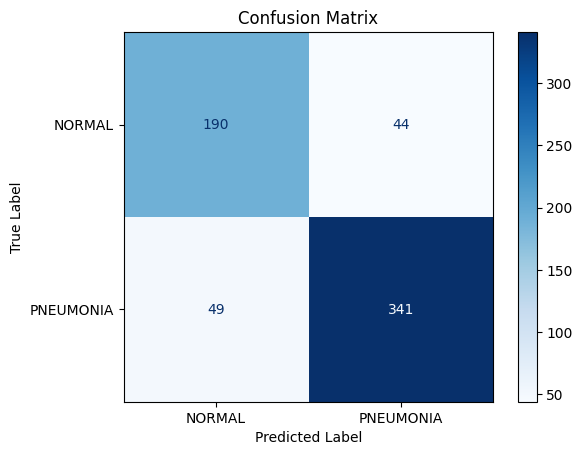

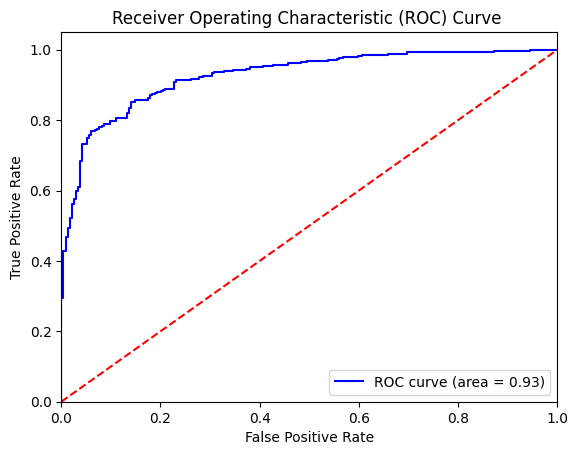

In [144]:
# Test
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),  # Normalizes to range [-1, 1]
    PatchExtractor(patch_size=patch_size, stride=stride)
])


test_dataset_ = datasets.ImageFolder(root='/kaggle/input/chest-xray-pneumonia/chest_xray/test', transform=test_transforms)

test_loader_ = DataLoader(test_dataset_, batch_size=1, shuffle=False, num_workers=4)

all_predictions_simple = []
all_labels_simple = []
all_probabilities_simple = []
with torch.no_grad(): 
    for images, labels in test_loader_:

        images = images.to('cuda')
        labels = labels.to('cuda')


        outputs = model.inference(images)
        

        probabilities = torch.sigmoid(outputs).squeeze().cpu().numpy() 


        predicted_class = (probabilities >= 0.5).astype(float)
     
        

        all_predictions_simple.append(predicted_class)
        all_labels_simple.append(labels.cpu().numpy())
        all_probabilities_simple.append(probabilities)


all_predictions_simple = np.array(all_predictions_simple)
all_labels_simple = np.array(all_labels_simple)

report = classification_report(all_labels_simple, all_predictions_simple, target_names=['NORMAL', 'PNEUMONIA'])
print(report)


plot_confusion_matrix(all_labels_simple, all_predictions_simple, class_names=['NORMAL', 'PNEUMONIA'])


plot_roc_auc(all_labels_simple, all_probabilities_simple)

# Model Result Interpretation

### Classification Metrics

The Vision Transformer (ViT) model, even after being trained for only **one epoch**, shows promising results on the test set:

- **Precision**: 
   - For the **NORMAL** class, the precision is 0.79, meaning that out of all the instances predicted as normal, 79% were correctly classified.
   - For the **PNEUMONIA** class, the precision is 0.89, which indicates that 89% of the pneumonia predictions were accurate.
   
- **Recall**: 
   - For **NORMAL** cases, the recall is 0.81, meaning that 81% of actual normal cases were correctly identified.
   - For **PNEUMONIA** cases, the recall is 0.87, meaning 87% of the actual pneumonia cases were correctly classified by the model.
   
- **F1-Score**: 
   - The F1-score balances precision and recall. For the **NORMAL** class, it is 0.80, while for **PNEUMONIA**, it is 0.88, reflecting a strong ability to detect pneumonia.
   
- **Accuracy**: 
   - The model achieves an overall accuracy of **85%**, meaning that 85% of the total 624 images were correctly classified.

- **Macro Average**: 
   - The macro average precision, recall, and F1-score are 0.84, indicating the model's balanced performance across both classes.

- **Weighted Average**: 
   - The weighted average F1-score is 0.85, slightly favoring the larger class (PNEUMONIA), which has more examples in the dataset.

### ROC Curve and AUC

The **ROC-AUC curve** shows an **area under the curve (AUC)** of **0.93**, which indicates excellent discriminative ability. The model is able to separate **normal** from **pneumonia** cases effectively, with minimal overlap between the two classes.

### Areas for Improvement

Despite the strong initial performance, there are several ways the model could be further improved:

- **More Training Epochs**: The model was trained for only **one epoch**, which limits its ability to fully learn the data representation. Increasing the number of epochs would likely lead to better performance, especially in terms of recall for normal cases and overall accuracy.
  
- **Hyperparameter Tuning**: Adjusting the learning rate, batch size, and optimizer settings can help the model converge more effectively and reduce overfitting.

- **Data Augmentation**: While this model already includes basic augmentations, more advanced techniques (like CutMix, MixUp, or adversarial training) could further enhance its robustness to variations in the data.

- **Model Regularization**: Techniques such as dropout and weight decay could be further adjusted to improve generalization, especially as more epochs are introduced.

- **Training on Larger Datasets**: Increasing the diversity and size of the training set could help improve the model's ability to generalize to unseen data, especially given the variability in medical imaging.

### Comparison with Classical CNNs

Classical CNN models typically require **many more epochs** to converge on similar tasks, especially when processing complex medical images. CNNs rely on convolutional layers to extract local features, whereas Vision Transformers leverage self-attention mechanisms to capture global context more effectively.

- **Training Time**: CNNs often need 20–50 epochs to reach similar levels of performance, whereas the Vision Transformer achieves strong results after just one epoch. However, the ViT might need more epochs to reach its full potential and outperform CNNs.
  
- **Feature Representation**: Vision Transformers excel at capturing global relationships between patches, while CNNs are better at detecting local features. For medical imaging tasks where global context is crucial (like identifying patterns across an X-ray), Vision Transformers may have an edge.

- **Efficiency**: CNNs can be computationally cheaper to train due to their use of convolutional operations, while Vision Transformers may require more memory and compute resources due to their reliance on self-attention.

In conclusion, the Vision Transformer model performs remarkably well after only one epoch, but with further training and optimization, its performance could surpass that of classical CNNs, especially in tasks requiring global context like pneumonia detection.


# Future Potential of Vision Transformers in Computer Vision

Vision Transformers (ViTs) have great potential for various computer vision tasks beyond classification. They can be adapted for **image segmentation**, where their ability to capture long-range dependencies may help in generating precise segmentations. In **object detection**, ViTs offer improved object localization by attending to global and local features. Additionally, ViTs can be used in **image generation** and **video understanding** tasks, leveraging their attention mechanisms to model complex relationships in data. Their flexibility in capturing global context makes them promising for advanced applications like medical imaging and action recognition in videos.
